In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [2]:
BASE_DIR = 'Gender_Dataset/utkface_aligned_cropped/UTKFace'

In [3]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.iloc[1000]

image     Gender_Dataset/utkface_aligned_cropped/UTKFace...
age                                                      16
gender                                                    1
Name: 1000, dtype: object

In [5]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

In [6]:
from PIL import Image
import albumentations as A

def extract_features(images):
    features = []

    # Define the data augmentation transformations
    transform = A.Compose([
        A.Rotate(limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.GaussNoise(p=0.5),
        A.Blur(p=0.5),
        A.Resize(160, 160)
    ])

    for image in tqdm(images):
        img = load_img(image,grayscale=True)
        img = img.resize((160, 160), Image.ANTIALIAS)
        img = np.array(img)

        # Perform data augmentation on the image
        augmented = transform(image=img)
        augmented_image = augmented["image"]

        features.append(augmented_image)

    features = np.array(features)
    features = features.reshape(len(features), 160, 160, 1)
    return features

In [7]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [8]:
X.shape

(23708, 160, 160, 1)

In [9]:
#Conversion of gender and age into a numpy array
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [10]:
input_shape = (160, 160, 1)
inputs = Input((input_shape))

In [11]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model


# Convolutional layers

x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten layer
x = Flatten()(x)

# Fully connected layers
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Define separate outputs
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
age_output = Dense(1, activation='relu', name='age_output')(x)

# Create the model with both outputs
model = Model(inputs=inputs, outputs=[gender_output, age_output])

# Unfreeze all layers
for layer in model.layers:
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Adjust learning rate dynamically
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001, mode='auto')  
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [13]:
from tensorflow.keras.callbacks import Callback

class ConvolutionCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('gender_output_accuracy') >= 0.93:
            print("Reached greater than 93.0% accuracy, so canceling training!")
            self.model.stop_training = True

convolutionCallback = ConvolutionCallback()

callbacks = [reduce_lr, convolutionCallback, early_stopping]


In [14]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2, callbacks = callbacks)

Epoch 1/30
593/593 [==============================] - 699s 1s/step - loss: 23.5397 - gender_output_loss: 0.7775 - age_output_loss: 13.0140 - gender_output_accuracy: 0.5510 - age_output_accuracy: 0.0378 - val_loss: 49.7614 - val_gender_output_loss: 0.6828 - val_age_output_loss: 42.6123 - val_gender_output_accuracy: 0.5742 - val_age_output_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/30
593/593 [==============================] - 690s 1s/step - loss: 17.4918 - gender_output_loss: 0.7105 - age_output_loss: 11.0229 - gender_output_accuracy: 0.5554 - age_output_accuracy: 0.0521 - val_loss: 39.4478 - val_gender_output_loss: 0.7769 - val_age_output_loss: 33.8158 - val_gender_output_accuracy: 0.5814 - val_age_output_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/30
593/593 [==============================] - 691s 1s/step - loss: 14.6970 - gender_output_loss: 0.6723 - age_output_loss: 10.0423 - gender_output_accuracy: 0.6081 - age_output_accuracy: 0.0539 - val_loss: 36.1590 - val_gender_output_loss: 0.70

Epoch 23/30
593/593 [==============================] - 804s 1s/step - loss: 7.3727 - gender_output_loss: 0.4185 - age_output_loss: 5.8799 - gender_output_accuracy: 0.8012 - age_output_accuracy: 0.0143 - val_loss: 23.0870 - val_gender_output_loss: 0.5487 - val_age_output_loss: 21.4660 - val_gender_output_accuracy: 0.7482 - val_age_output_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 24/30
593/593 [==============================] - 815s 1s/step - loss: 7.2562 - gender_output_loss: 0.4082 - age_output_loss: 5.7700 - gender_output_accuracy: 0.8040 - age_output_accuracy: 0.0142 - val_loss: 23.3818 - val_gender_output_loss: 0.5362 - val_age_output_loss: 21.7645 - val_gender_output_accuracy: 0.7531 - val_age_output_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 25/30
593/593 [==============================] - 776s 1s/step - loss: 7.2053 - gender_output_loss: 0.4073 - age_output_loss: 5.7158 - gender_output_accuracy: 0.8021 - age_output_accuracy: 0.0119 - val_loss: 28.0733 - val_gender_output_loss:

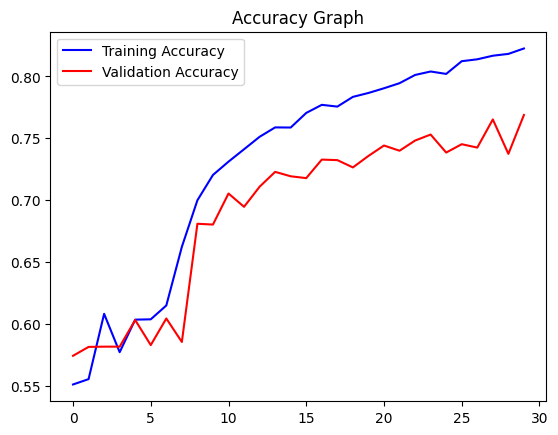

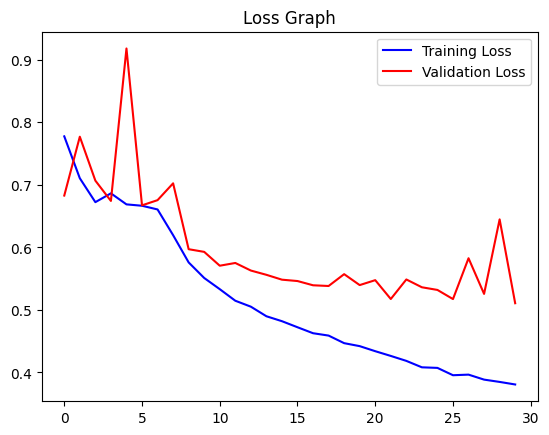

In [16]:
# Plot results for gender
acc = history.history['gender_output_accuracy']
val_acc = history.history['val_gender_output_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_output_loss']
val_loss = history.history['val_gender_output_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


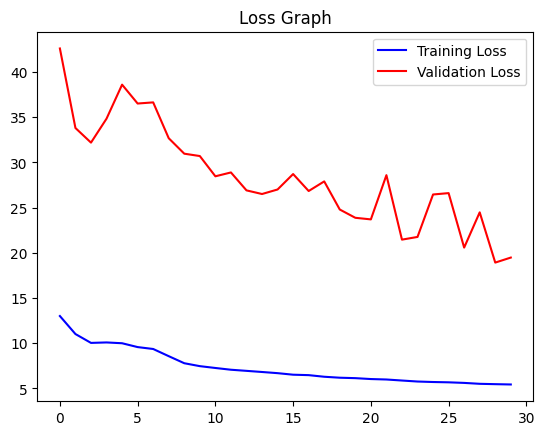

In [17]:
# plot results for age
loss = history.history['age_output_loss']
val_loss = history.history['val_age_output_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [38]:
# Save the model
model.save("Gender_Age_model.h5")

In [12]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model('Gender_Age_model.h5')

def predict_gender_age(model, X, y_gender, y_age, gender_dict):
    male_indices = [i for i, gender in enumerate(y_gender) if gender == 1]
    female_indices = [i for i, gender in enumerate(y_gender) if gender == 0]
    num_images_per_gender = min(len(male_indices), len(female_indices), 50)
    male_samples = random.sample(male_indices, num_images_per_gender)
    female_samples = random.sample(female_indices, num_images_per_gender)

    samples = male_samples + female_samples
    num_images = len(samples)
    age_classes = len(set(y_age))
    age_samples = [random.choice(range(age_classes)) for _ in range(num_images)]

    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axs.flat):
        sample_index = samples[i]
        image = X[sample_index]

        if image.ndim == 3 and image.shape[2] == 3:
            # RGB image
            grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            # Grayscale image
            grayscale_image = image

        ax.imshow(grayscale_image, cmap='gray')
        ax.axis('off')

        original_gender = gender_dict[y_gender[sample_index]]
        original_age = y_age[sample_index]

        if grayscale_image.ndim == 2:
            # Expand dimensions for grayscale image
            grayscale_image = np.expand_dims(grayscale_image, axis=-1)

        pred = model.predict(np.expand_dims(grayscale_image, axis=0))
        predicted_gender = gender_dict[np.argmax(pred[0])]
        predicted_age = np.argmax(pred[1])

        ax.set_title(f'Original: Gender-{original_gender}, Age-{original_age}\nPredicted: Gender-{predicted_gender}, Age-{predicted_age}')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a trained model named 'model', the input images 'X', gender labels 'y_gender',
# age labels 'y_age', and the gender dictionary 'gender_dict'
predict_gender_age(model, X, y_gender, y_age, gender_dict)

1/1 [==============================] - 0s 31ms/step


In [24]:
def predict(image_index):
  print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
  # predict from model
  pred = model.predict(X[image_index].reshape(1, 160, 160, 1))
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(X[image_index].reshape(160, 160));

1/1 [==============================] - 0s 142ms/step
pred = [array([[0.6055843]], dtype=float32), array([[0.]], dtype=float32)]
Predicted Gender: Female Predicted Age: 0


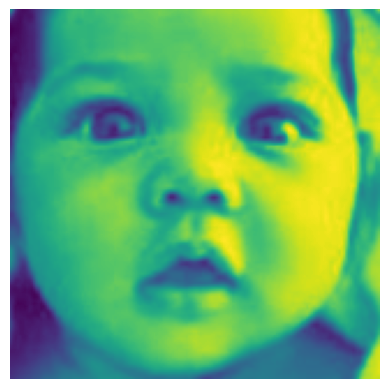

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model('Gender_Age_model.h5')
gender_dict = {0: 'Male', 1: 'Female'}
def predict(img_path):
  # Load the image using OpenCV
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

  # Resize the image to the desired shape (160x160)
  img = cv2.resize(img, (160, 160))

  # Reshape the image for model input
  img = img.reshape(1, 160, 160, 1)

  # Predict using the model
  pred = model.predict(img)
  print(f'pred = {pred}')
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
  plt.axis('off')
  plt.imshow(img.reshape(160, 160))

img_path = './2.jpg'
predict(img_path)

In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('Gender_Age_model.h5')
# Define the gender labels
gender_dict = {0: 'Male', 1: 'Female'}
# Load the face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Open the webcam
video_capture = cv2.VideoCapture(0)
while True:
    # Read the video frame
    ret, frame = video_capture.read()

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Process each detected face
    for (x, y, w, h) in faces:
        # Extract the face region
        face = gray[y:y+h, x:x+w]

        # Resize the face image to the required input size of the model
        resized_face = cv2.resize(face, (160, 160))

        normalized_face = np.expand_dims(resized_face, axis=-1)
        normalized_face = np.expand_dims(normalized_face, axis=0)

        pred = model.predict(normalized_face)
        pred_gender = gender_dict[round(pred[0][0][0])]
        pred_age = int(round(pred[1][0][0]))

        # Draw bounding box and predicted gender label on the frame
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, pred_gender, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, ((y+h)/(x+w)), (0, 255, 0), 2)
        cv2.putText(frame, str(pred_age), (x+w-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Webcam', frame)

    # Exit loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the window
video_capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 182ms/step
